## Graph neural network (GNN)

$$h_{i}^{t+1} = f\left(h_{i}^{t} W + \sum_{j \in N (i)} \frac{1}{C_{i,j}} h_{j}^{t} U \right)$$

Old representation times a weight matrix:
$$h_{i}^{t} W $$

Information from neighbors times a weight matrix:
$$h_{j}^{t} U $$

### Aggregation function:

Sum over all transformed neighbor representations

$$\sum_{j \in N (i)} \frac{1}{C_{i,j}}$$

Normalize the vectors differently for each neighbor
$$\frac{1}{C_{i,j}}$$

The sum is a $permutation-invariant$ aggregation function -> Insensitive to $order$

Each node's updated value becomes a weighting of its previous value+weightning of it's neighbors values.

-> Agg function can be mean, max, concatenation, etc.



Collapse $W_{self}$ and $W_{neigh}$ into $W$ by adding self-loops to the adjacency matrix $A$:
$$H^{(k+1)} = \sigma \left( (A+I)H^{(k)} W^{k+1} \right)$$

In [4]:
import torch #tensors
import torch.nn as nn #weight and bias
import torch.nn.functional as F #activation functions
from torch.optim import SGD
from torch_geometric.data import Data #graph data structure
from torch.optim import SGD

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

### Graph data
<div style="text-align:center; display: flex; justify-content: center;">
  <table>
    <tr>
      <th>Rosette number</th>
      <th>Nodes</th>
      <th>Edges</th>
    </tr>
    <tr>
      <td>3</td>
      <td>11157</td>
      <td>7572</td>
    </tr>
    <tr>
      <td>6</td>
      <td>9568</td>
      <td>5245</td>
    </tr>
    <tr>
      <td>7</td>
      <td>11635</td>
      <td>9257</td>
    </tr>
    <tr>
      <td>11</td>
      <td>13667</td>
      <td>13051</td>
    </tr>
    <tr>
      <td>12</td>
      <td>10617</td>
      <td>6870</td>
    </tr>
    <tr>
      <td>13</td>
      <td>13260</td>
      <td>14395</td>
    </tr>
    <tr>
      <td>14</td>
      <td>10704</td>
      <td>7635</td>
    </tr>
    <tr>
      <td>15</td>
      <td>10131</td>
      <td>8655</td>
    </tr>
    <tr>
      <td>18</td>
      <td>11117</td>
      <td>7991</td>
    </tr>
    <tr>
      <td>19</td>
      <td>10248</td>
      <td>6689</td>
    </tr>
  </table>
</div>



In [ ]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [6]:
rosettes = [3,6,7,11,12,13,14,15,18,19]
nodes, edges, distances = graph_r(rosettes[0])

In [8]:
nodes, edges, distances = graph_r(rosettes[0])

node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

In [9]:
graph

Data(x=[11157, 8], edge_index=[2, 7572], num_nodes=11157, num_edges=7572)

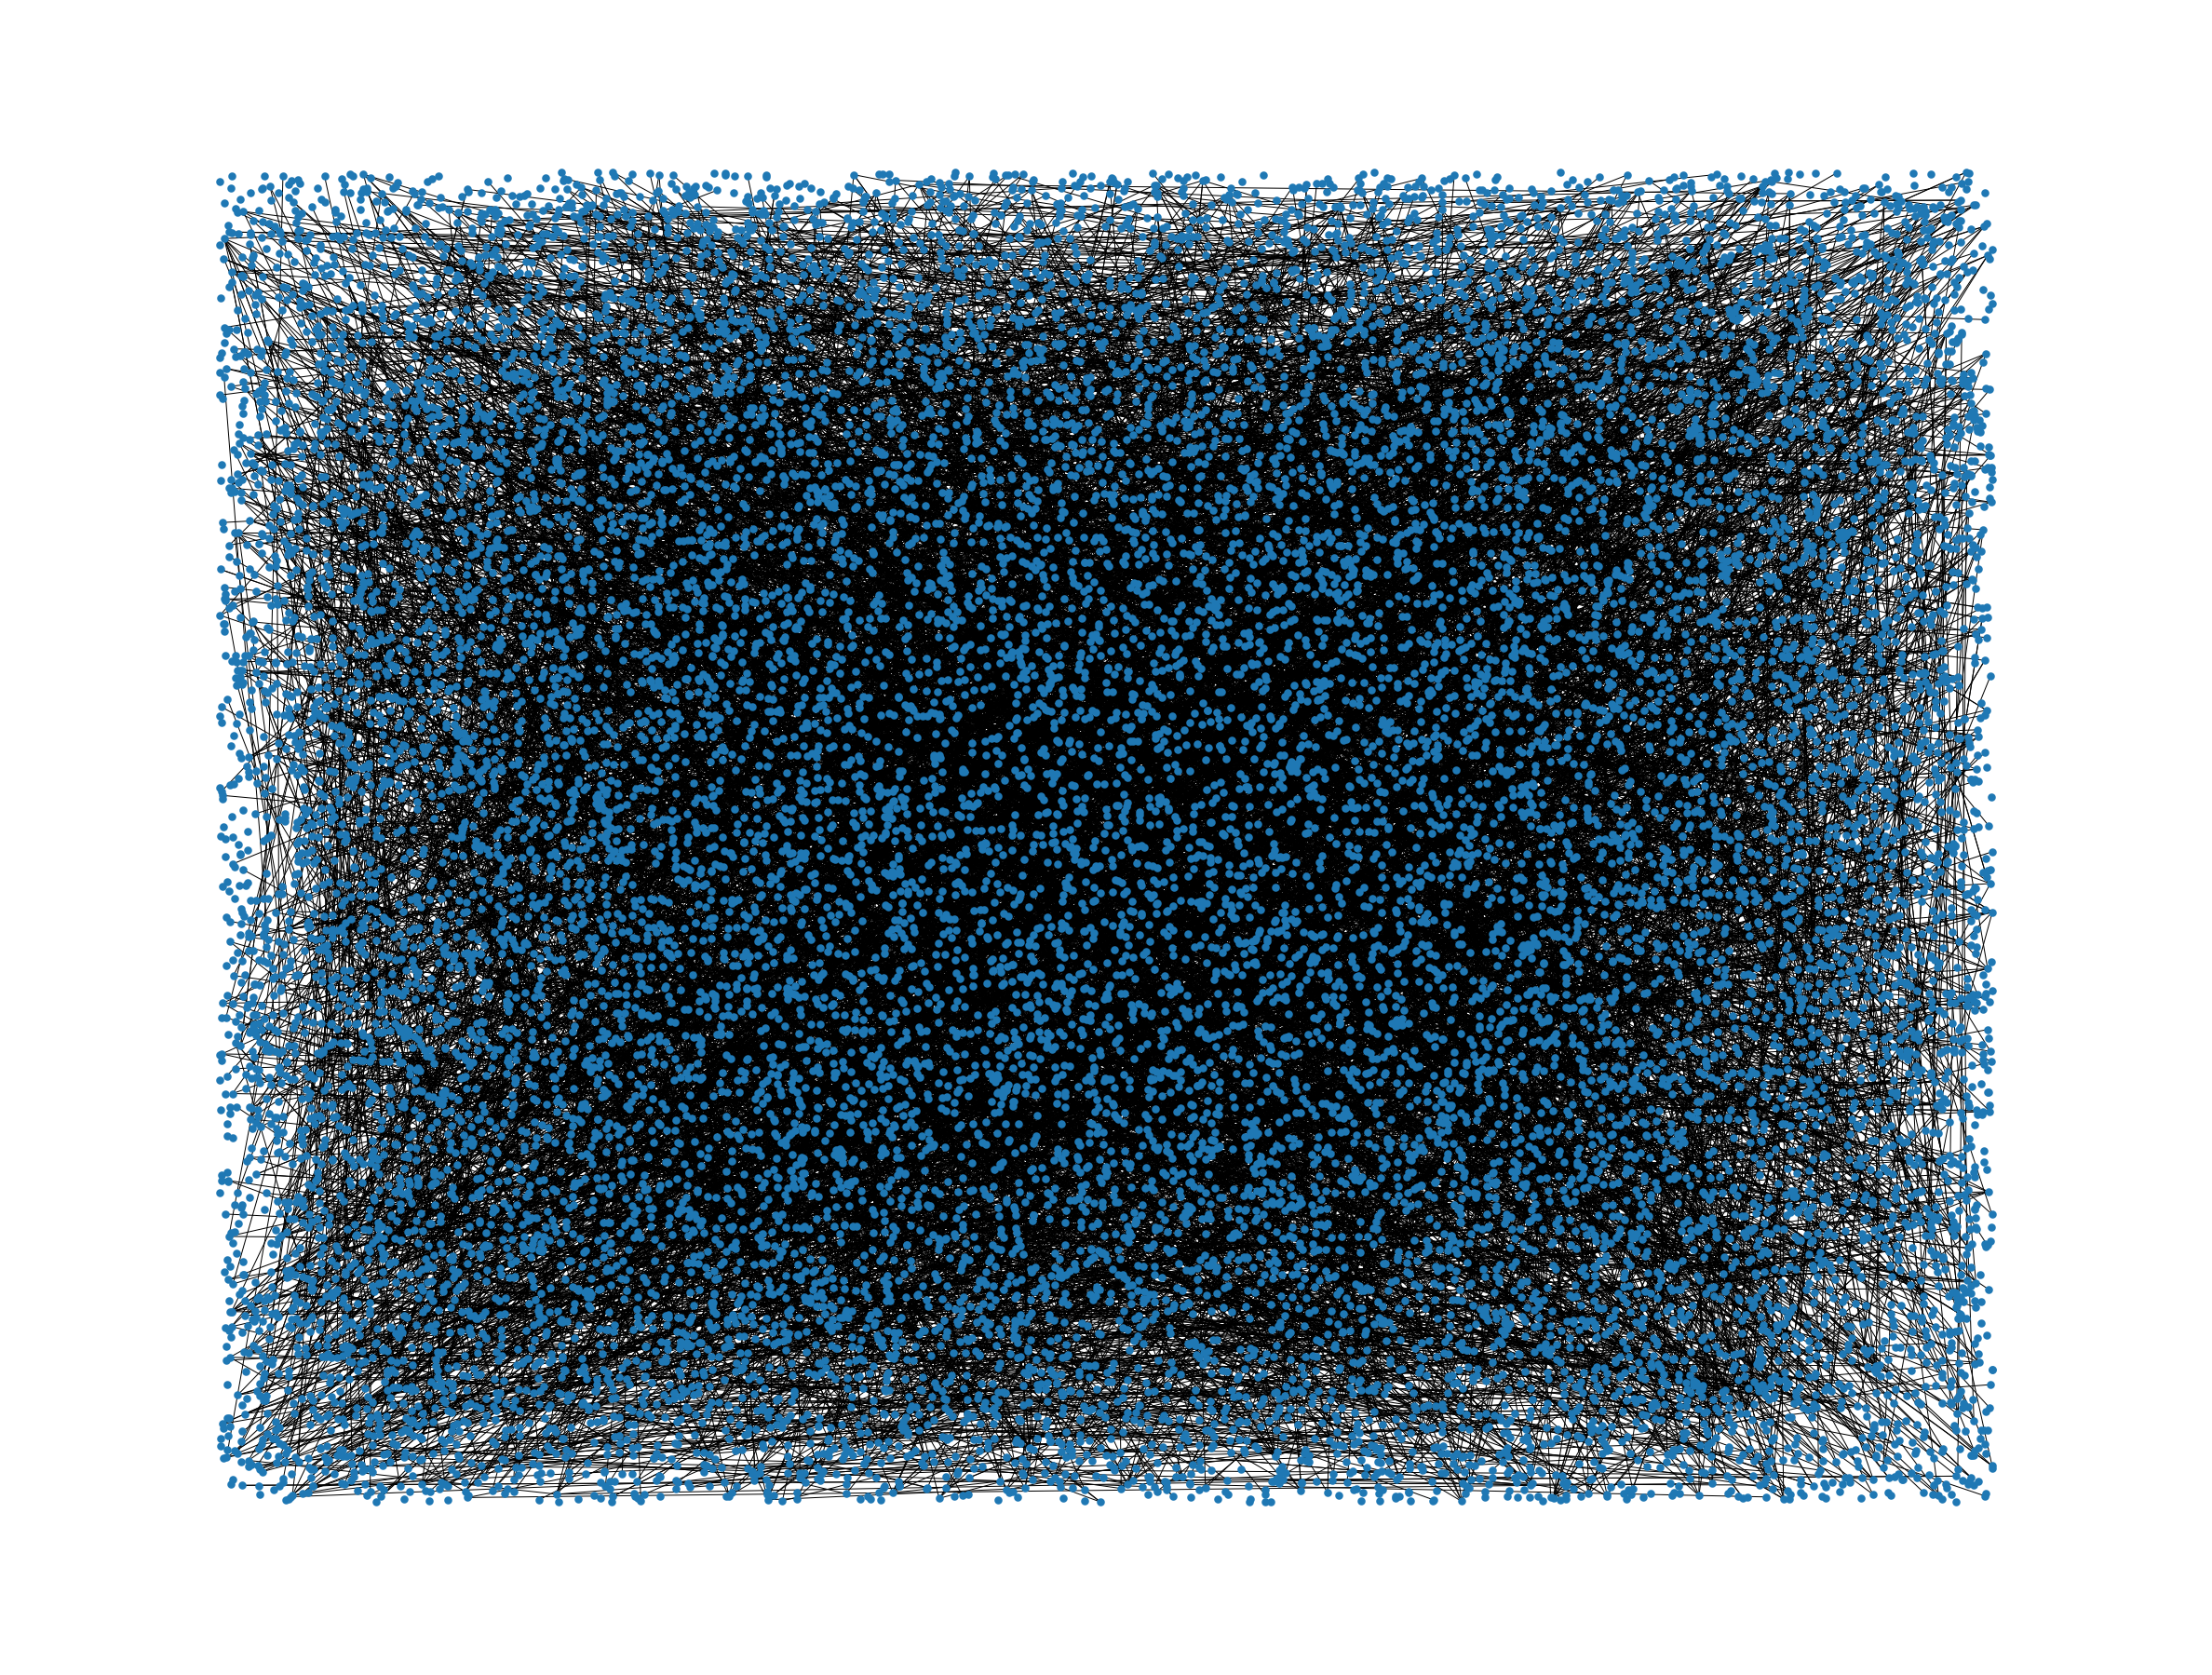

In [13]:
import networkx as nx
from torch_geometric.utils import to_networkx
networkx_graph = to_networkx(graph)
nx.draw_random(networkx_graph, arrows=False, width=0.2, node_size=0.5, with_labels=False)

In [10]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x